In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
from prophet import Prophet

db_connection = mysql.connector.connect(
  host="",
  user="",
  passwd="",
  database="mps_data"
)
cursor = db_connection.cursor()

query = '''
SELECT
       DATE_FORMAT(date_time, '%Y-%m-%d 00:00:00') as day, 
       COUNT(*) as count
FROM use_of_force
WHERE date_time > '2019-01-01 00:00:00' AND PrimaryConduct > 0
GROUP BY day;
'''
time_series_daily = pd.read_sql(query, db_connection)

time_series_daily['day'] = pd.to_datetime(time_series_daily['day'])
time_series_daily.rename(columns={'day': 'ds', 'count': 'y'}, inplace=True)

C:\Users\Nikita\AppData\Local\Temp/ipykernel_13264/585051229.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  time_series_daily = pd.read_sql(query, db_connection)


#### Determination of holidays and outliers on a daily level

In [2]:
#define a prophet model object
m = Prophet()
#add the UK specific holidays to the model
m.add_country_holidays(country_name='UK')
#fit the model with the time series data
m.fit(time_series_daily)
#create a dataframe with the future dates
future = m.make_future_dataframe(periods=365, freq='D')
#make a prediction for the future dates
forecast = m.predict(future)

19:00:37 - cmdstanpy - INFO - Chain [1] start processing
19:00:38 - cmdstanpy - INFO - Chain [1] done processing


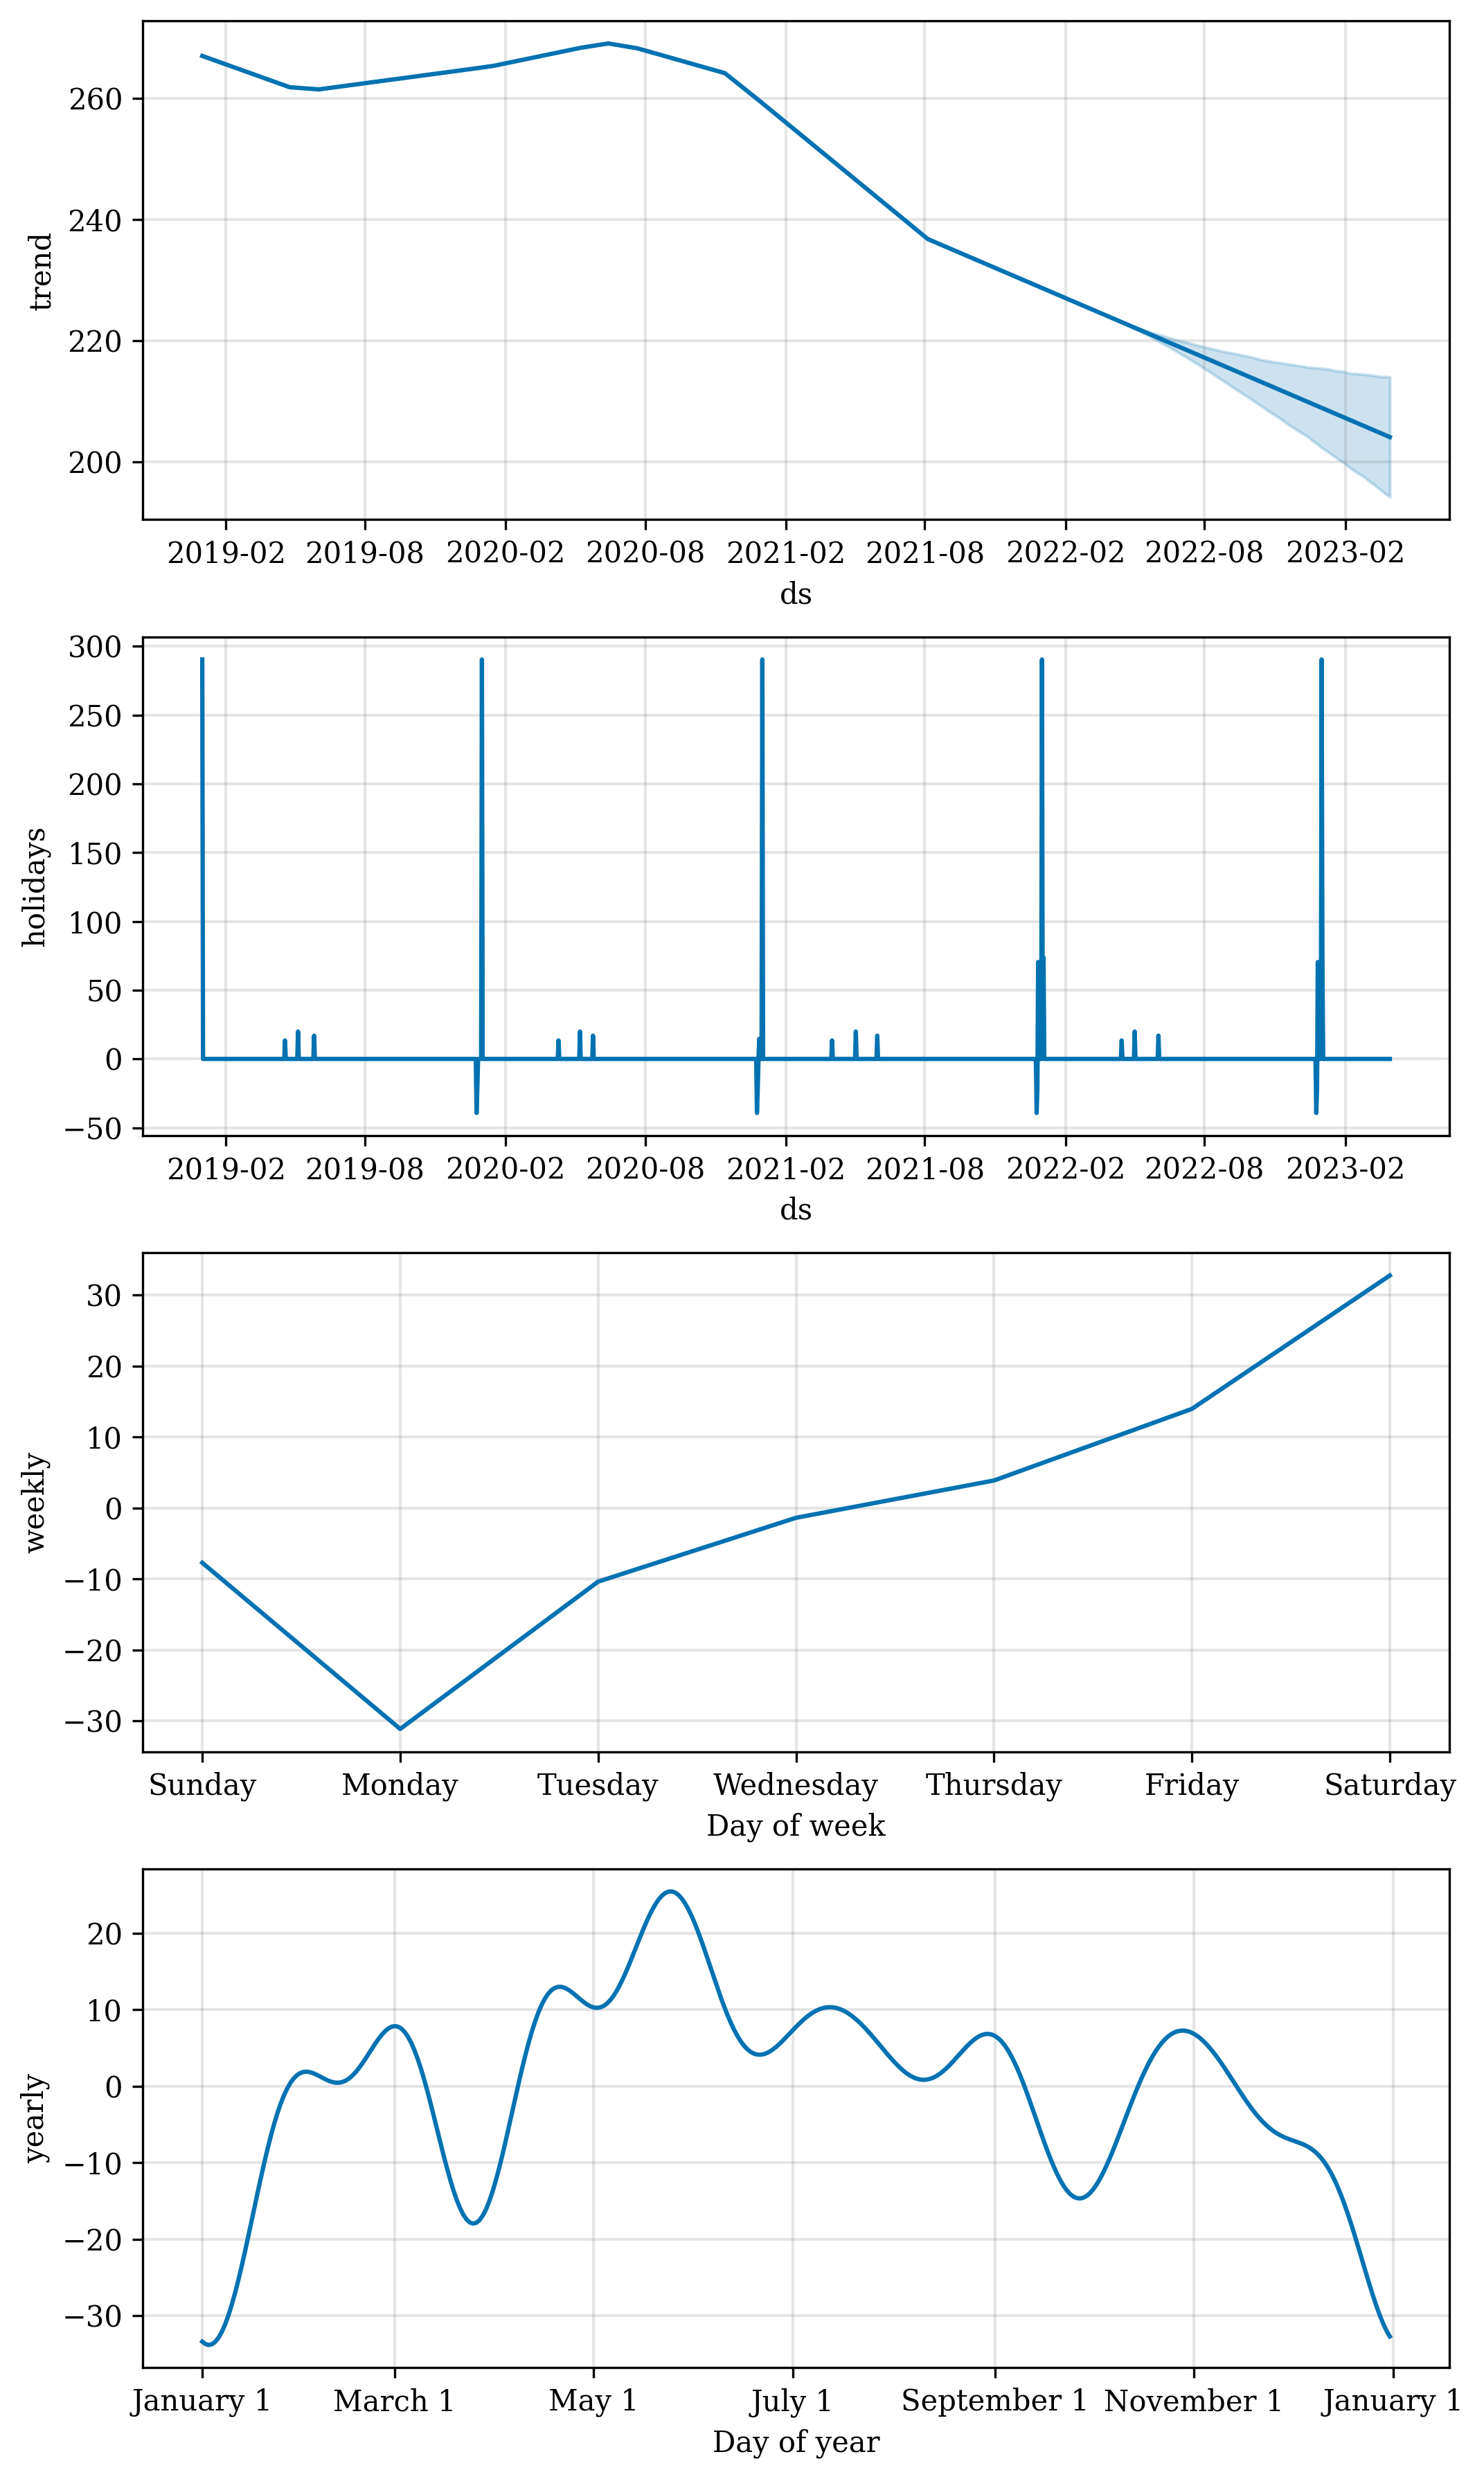

In [3]:
#plot the decomposed time series
fig2 = m.plot_components(forecast)
ax = fig2.gca()
fig = plt.gcf()
fig.set_size_inches(7, 12)
fig.dpi = 300
fig.savefig('prophet_forecast_components.png', bbox_inches='tight', dpi=300)

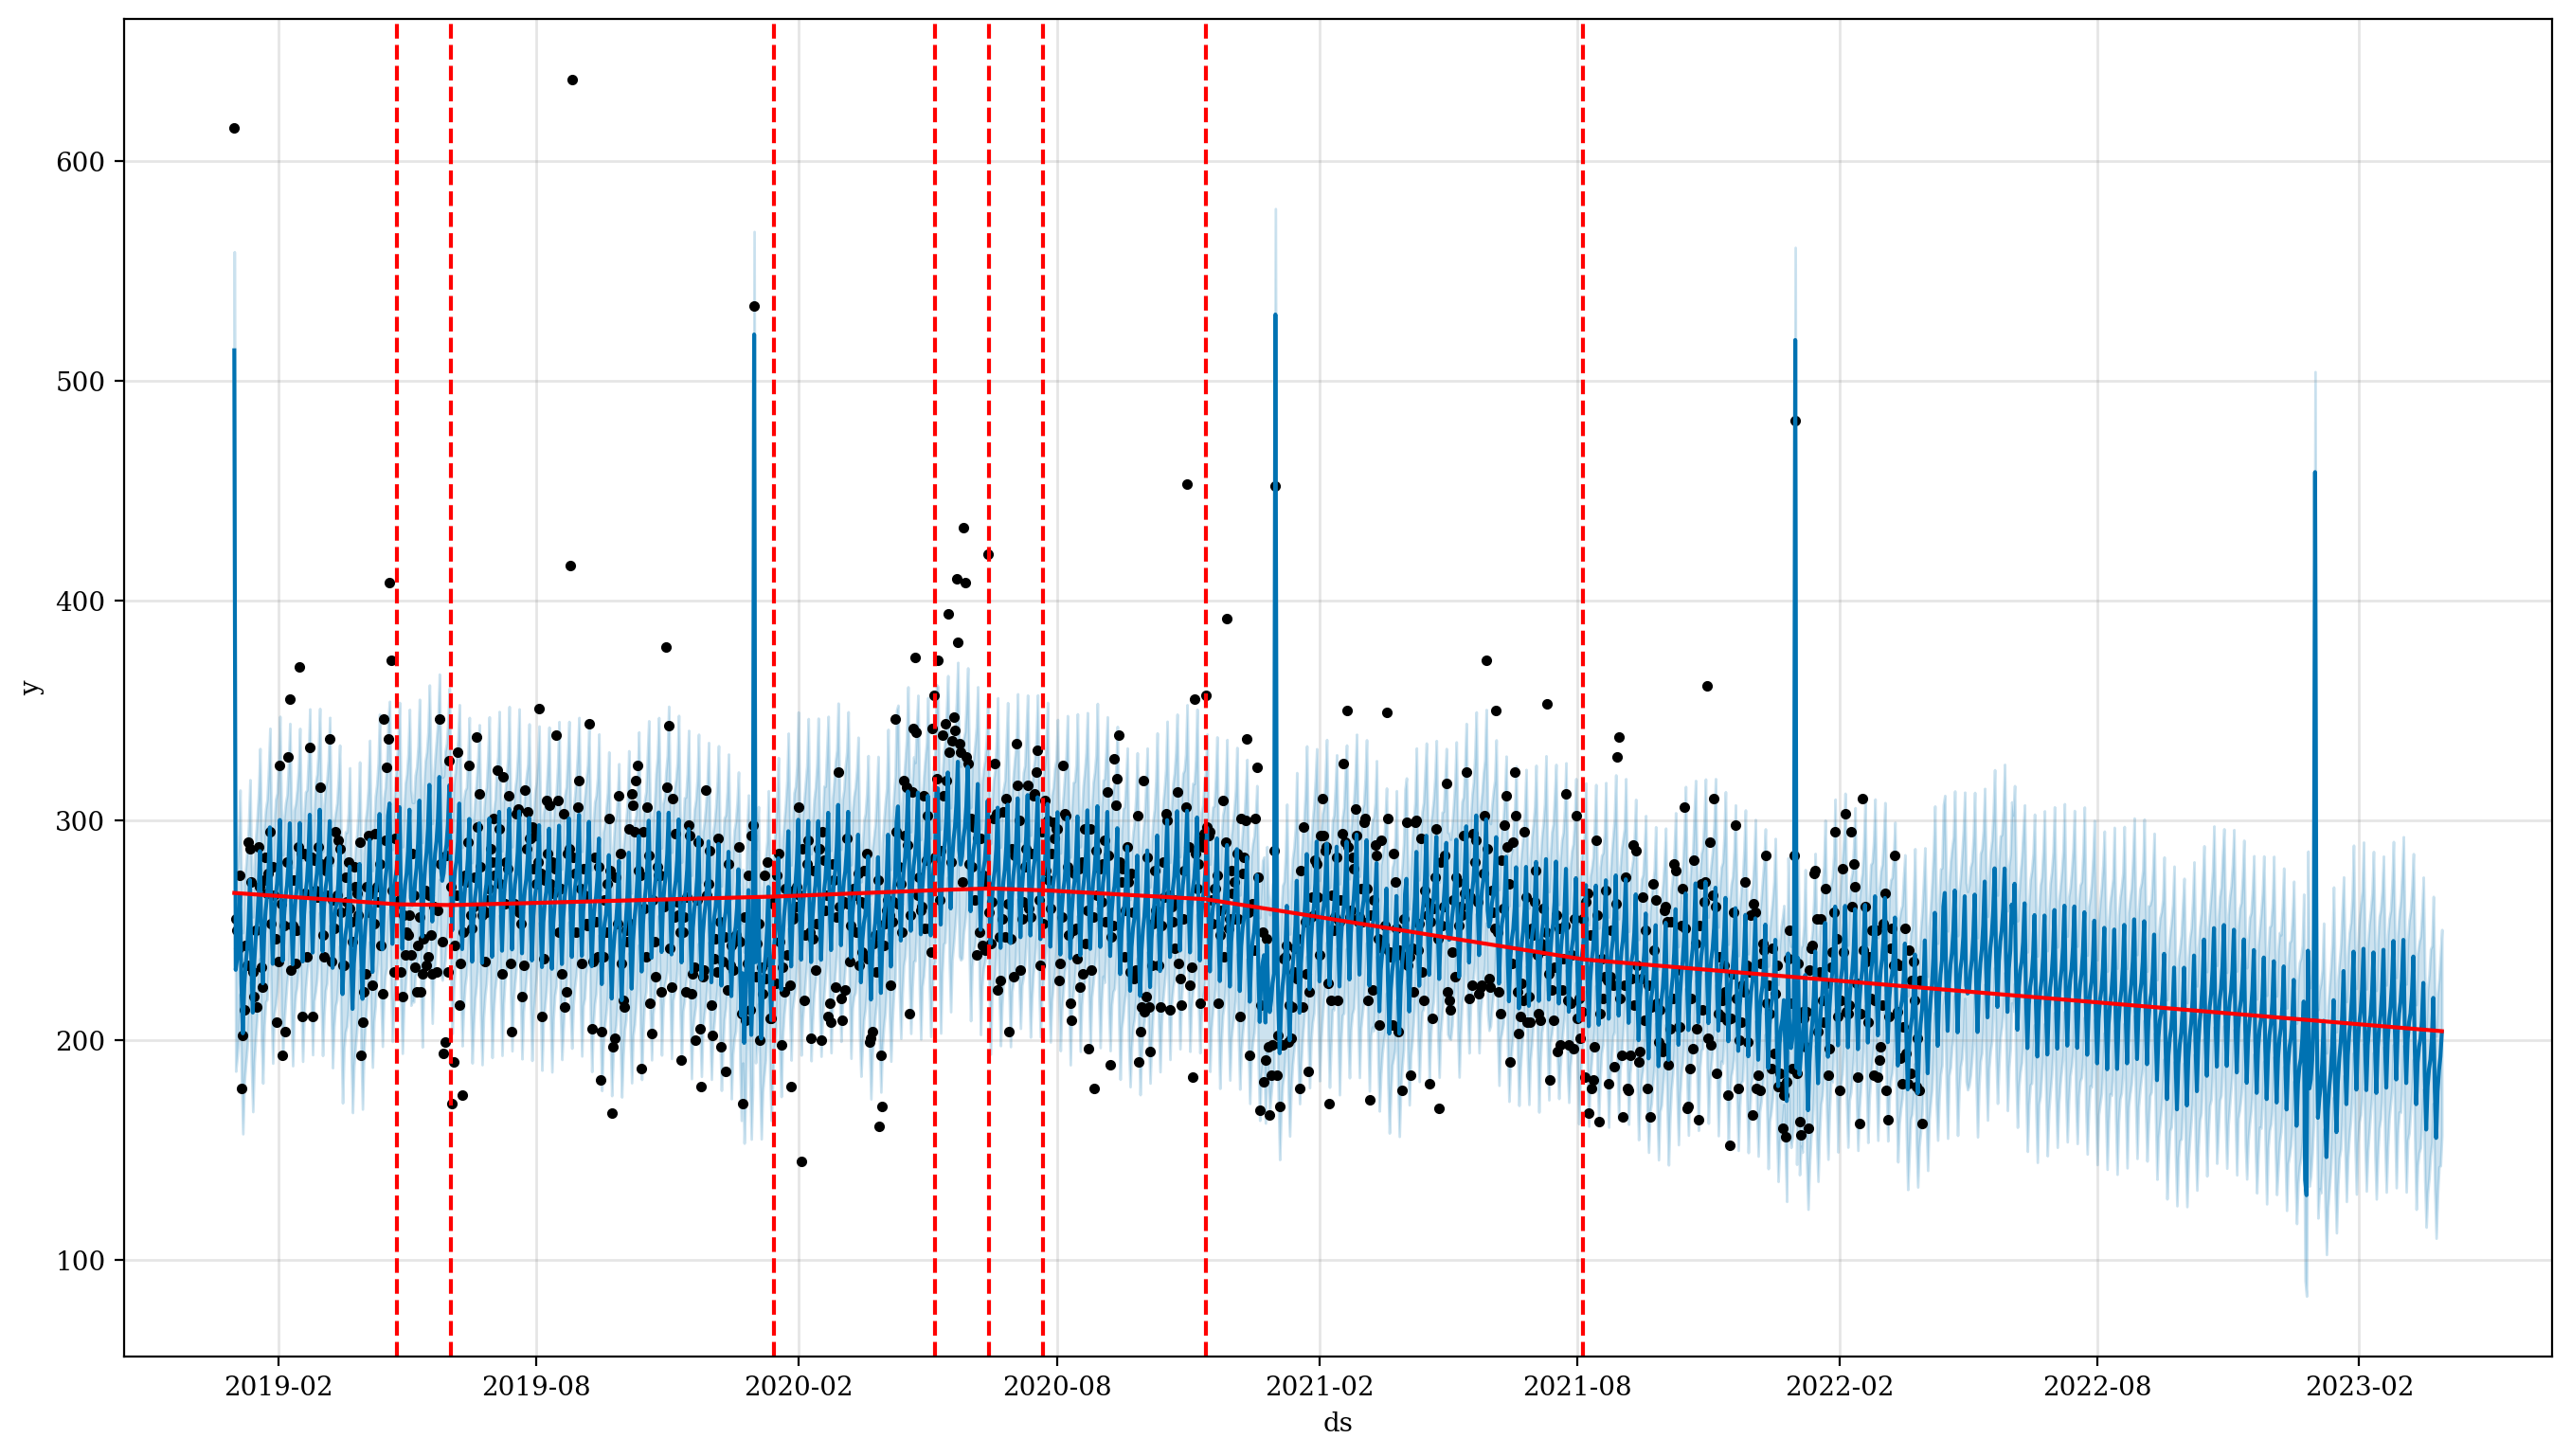

In [4]:
#plot the forecaset with changepoints for the trend
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
fig.set_size_inches(14, 8)
fig.dpi = 200
fig.savefig('prophet_forecast_with_trendchangepoints.png', bbox_inches='tight', dpi=300)

In [5]:
#detecting the dates where the actuals exceed the upper bound of the forecast for more than 10%
outlier_df = (forecast[['ds', 'yhat_upper']]
              .merge(time_series_daily[['ds', 'y']], on='ds', how='left')
              .assign(pct_above=lambda x: x['y'] / x['yhat_upper'] - 1)
              .query("pct_above > 0.1 & ds < '2022-02-01'"))

#extract the holidays from the UK calendar and create a dataframe with the dates and the holiday names
import holidays
uk_holidays = holidays.UK(years=[2019, 2020, 2021, 2022])
holidays_df = pd.DataFrame(list(uk_holidays.items()), 
                           columns=['Date', 'Holiday'])

#determine which outliers are not holidays and filter them
outlier_df = outlier_df[~outlier_df['ds'].isin(holidays_df['Date'])]
outlier_df.drop(['yhat_upper', 'y', 'pct_above'], 
                axis=1, inplace=True)
outlier_df['holiday'] = 'outlier'

#prepare the dataframes for merging
holidays_df.rename(columns={'Date': 'ds', 'Holiday': 'holiday'}, 
                   inplace=True)
holidays_df.set_index('ds', inplace=True)
outlier_df.set_index('ds', inplace=True)
#generate a dataframe with binary variables for each holiday and outlier
additional_variables = (pd.DataFrame(pd.date_range(start='2019-01-01', end='2022-12-31'), columns=['date'])
                        .set_index('date')
                        .merge(pd.get_dummies(holidays_df['holiday']).astype('int'), 
                               left_index=True, right_index=True, how='left')
                        .merge(pd.get_dummies(outlier_df['holiday']).astype('int'), 
                               left_index=True, right_index=True, how='left')
                        .fillna(0))

In [9]:
#upload the additional variables to the database 
#to use in the next time series models

cursor.execute("""
        CREATE TABLE IF NOT EXISTS rq3_add_variables (
            id INT NOT NULL AUTO_INCREMENT,
            date DATE,
            boxing_day INT,
            boxing_day_obs INT,
            christmas_day INT,
            christmas_day_obs INT,
            good_friday INT,
            may_day INT,
            new_years_day INT,
            new_years_day_obs INT,
            platinum_jubilee INT,
            spring_bank_holiday INT,
            state_funeral INT,
            outlier INT,
            PRIMARY KEY (id)
        );
               """)

for element in additional_variables.index.to_numpy():
    query = "INSERT INTO rq3_add_variables (date) VALUES (%s);"
    cursor.execute(query, (str(element),))
    
column_mapping = {
    'Boxing Day': 'boxing_day',
    'Boxing Day (Observed)': 'boxing_day_obs',
    'Christmas Day': 'christmas_day',
    'Christmas Day (Observed)': 'christmas_day_obs',
    'Good Friday': 'good_friday',
    'May Day': 'may_day',
    "New Year's Day": 'new_years_day',
    "New Year's Day (Observed)": 'new_years_day_obs',
    'Platinum Jubilee of Elizabeth II': 'platinum_jubilee',
    'Spring Bank Holiday': 'spring_bank_holiday',
    'State Funeral of Queen Elizabeth II': 'state_funeral',
    'outlier': 'outlier'
}

data_tuples = [(i+1, *[row[col] for col in column_mapping.keys()]) for i, (index, row) in enumerate(additional_variables.iterrows())]

cursor.execute("DROP TABLE IF EXISTS temp_table")
cursor.execute("""
    CREATE TEMPORARY TABLE temp_table (
        id INT PRIMARY KEY,
        boxing_day INT,
        boxing_day_obs INT,
        christmas_day INT,
        christmas_day_obs INT,
        good_friday INT,
        may_day INT,
        new_years_day INT,
        new_years_day_obs INT,
        platinum_jubilee INT,
        spring_bank_holiday INT,
        state_funeral INT,
        outlier INT
    )
""")

query = """
INSERT INTO temp_table
(id, boxing_day, boxing_day_obs, christmas_day, christmas_day_obs, good_friday, may_day, 
 new_years_day, new_years_day_obs, platinum_jubilee, spring_bank_holiday, state_funeral, outlier)
VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
"""
cursor.executemany(query, data_tuples)

query = """
UPDATE rq3_add_variables
JOIN temp_table ON rq3_add_variables.id = temp_table.id
SET 
    rq3_add_variables.boxing_day = temp_table.boxing_day,
    rq3_add_variables.boxing_day_obs = temp_table.boxing_day_obs,
    rq3_add_variables.christmas_day = temp_table.christmas_day,
    rq3_add_variables.christmas_day_obs = temp_table.christmas_day_obs,
    rq3_add_variables.good_friday = temp_table.good_friday,
    rq3_add_variables.may_day = temp_table.may_day,
    rq3_add_variables.new_years_day = temp_table.new_years_day,
    rq3_add_variables.new_years_day_obs = temp_table.new_years_day_obs,
    rq3_add_variables.platinum_jubilee = temp_table.platinum_jubilee,
    rq3_add_variables.spring_bank_holiday = temp_table.spring_bank_holiday,
    rq3_add_variables.state_funeral = temp_table.state_funeral,
    rq3_add_variables.outlier = temp_table.outlier
"""
cursor.execute(query)

db_connection.commit()

#### Prophet model for the daily data

In [6]:
#slice the time series view to get the train and test dataframes

#define the cutoff date as 60 days before the last date
cutoff = time_series_daily['ds'].max() - pd.DateOffset(days=60)
#use the cutoff date to split the dataframe into train and test
df_train = time_series_daily[time_series_daily['ds'] <= cutoff]
df_test = time_series_daily[time_series_daily['ds'] > cutoff]
#create an empty dataframe to store the predictions
predictions = pd.DataFrame()

In [7]:
#create and fit a new model
m = Prophet()
m.add_country_holidays(country_name='UK')
m.fit(time_series_daily)

#make predictions for the unseen data
future = m.make_future_dataframe(periods=60)
forecast = m.predict(future)
forecast = forecast[forecast['ds'] > cutoff]
predictions = pd.concat([predictions, forecast], ignore_index=True)
merged = pd.merge(df_test, predictions, on=['ds'], how='inner')

19:00:45 - cmdstanpy - INFO - Chain [1] start processing
19:00:46 - cmdstanpy - INFO - Chain [1] done processing


C:\Users\Nikita\AppData\Local\Temp/ipykernel_13264/2363175755.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(merged['ds'], merged['y'], label='Actual', linestyle='-', marker='o', markersize=5)
C:\Users\Nikita\AppData\Local\Temp/ipykernel_13264/2363175755.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(merged['ds'], merged['yhat'], label='Predicted', linestyle='--', marker='o', markersize=2)


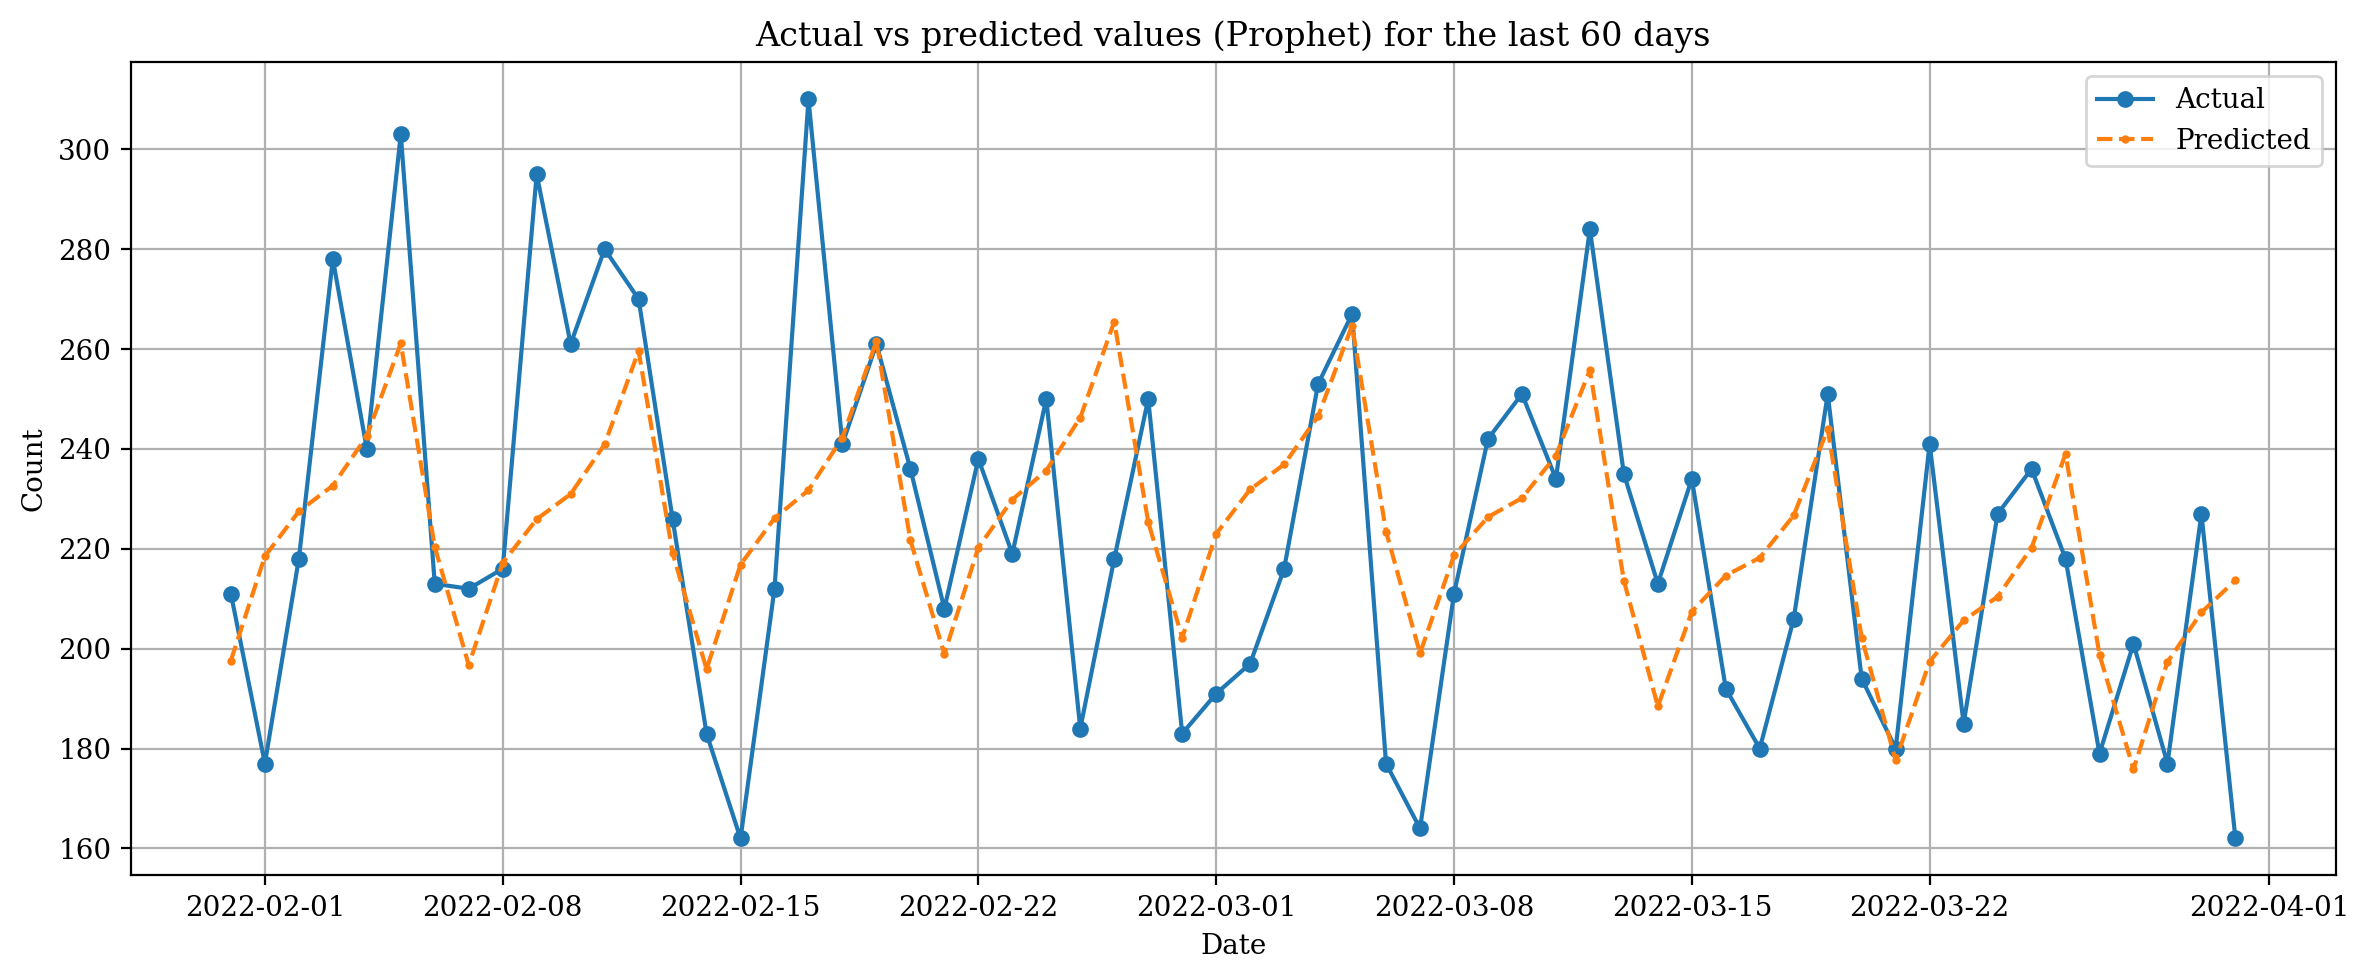

In [8]:
#visualise the actual vs predicted values for the last 60 observations (unseen by the model)
plt.figure(figsize=(12, 5), dpi=200)

plt.plot_date(merged['ds'], merged['y'], label='Actual', linestyle='-', marker='o', markersize=5)
plt.plot_date(merged['ds'], merged['yhat'], label='Predicted', linestyle='--', marker='o', markersize=2)

plt.legend()
plt.title('Actual vs predicted values (Prophet) for the last 60 days')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.savefig('prophet_actual_vs_predicted_daily.png')
plt.show()

In [9]:
#upload the daily predictions and true labels to the database

# cursor.execute("DROP TABLE IF EXISTS rq3_test_predictions_daily")
cursor.execute("""
               CREATE TABLE IF NOT EXISTS rq3_test_predictions_daily (
                    id INT NOT NULL AUTO_INCREMENT,
                    true_label INT,
                    prophet FLOAT,
                    lstm_nn FLOAT,
                    transformer_nn FLOAT,
                    PRIMARY KEY (id));
                    """)

data = [(int(element),) for element in merged['y'].to_numpy()]
query = "INSERT INTO rq3_test_predictions_daily (true_label) VALUES (%s);"
cursor.executemany(query, data)
db_connection.commit()
cursor.execute("DROP TABLE IF EXISTS temp_table")
cursor.execute("""
               CREATE TEMPORARY TABLE temp_table(
                    id SERIAL PRIMARY KEY, 
                    prophet FLOAT);
                """)

data = [(float(element), i+1) for i, element in enumerate(merged['yhat'].to_numpy())]
query = "INSERT INTO temp_table(prophet, id) VALUES (%s, %s);"
cursor.executemany(query, data)

query = """
    UPDATE rq3_test_predictions_daily  
    JOIN temp_table 
    ON rq3_test_predictions_daily.id = temp_table.id
    SET 
        rq3_test_predictions_daily.prophet = temp_table.prophet;
"""
cursor.execute(query)
cursor.execute("DROP TABLE temp_table;")

db_connection.commit()

### Prophet model for hourly data

In [10]:
query = '''
SELECT
       DATE_FORMAT(date_time, '%Y-%m-%d %H:00:00') as hour, 
       COUNT(*) as count
FROM use_of_force
WHERE date_time > '2019-01-01 00:00:00' AND PrimaryConduct > 0
GROUP BY hour;
'''
time_series_hourly = pd.read_sql(query, db_connection)

time_series_hourly['hour'] = pd.to_datetime(time_series_hourly['hour'])
time_series_hourly.set_index('hour', inplace=True)

time_series_hourly = time_series_hourly.resample('H').sum()

time_series_hourly = time_series_hourly.reset_index()
time_series_hourly.columns = ['ds', 'y']

C:\Users\Nikita\AppData\Local\Temp/ipykernel_13264/934011564.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  time_series_hourly = pd.read_sql(query, db_connection)


In [11]:
m = Prophet()
m.add_country_holidays(country_name='UK')
m.fit(time_series_hourly)

future = m.make_future_dataframe(periods=24*365, freq='H')
forecast = m.predict(future)

19:00:54 - cmdstanpy - INFO - Chain [1] start processing
19:01:08 - cmdstanpy - INFO - Chain [1] done processing


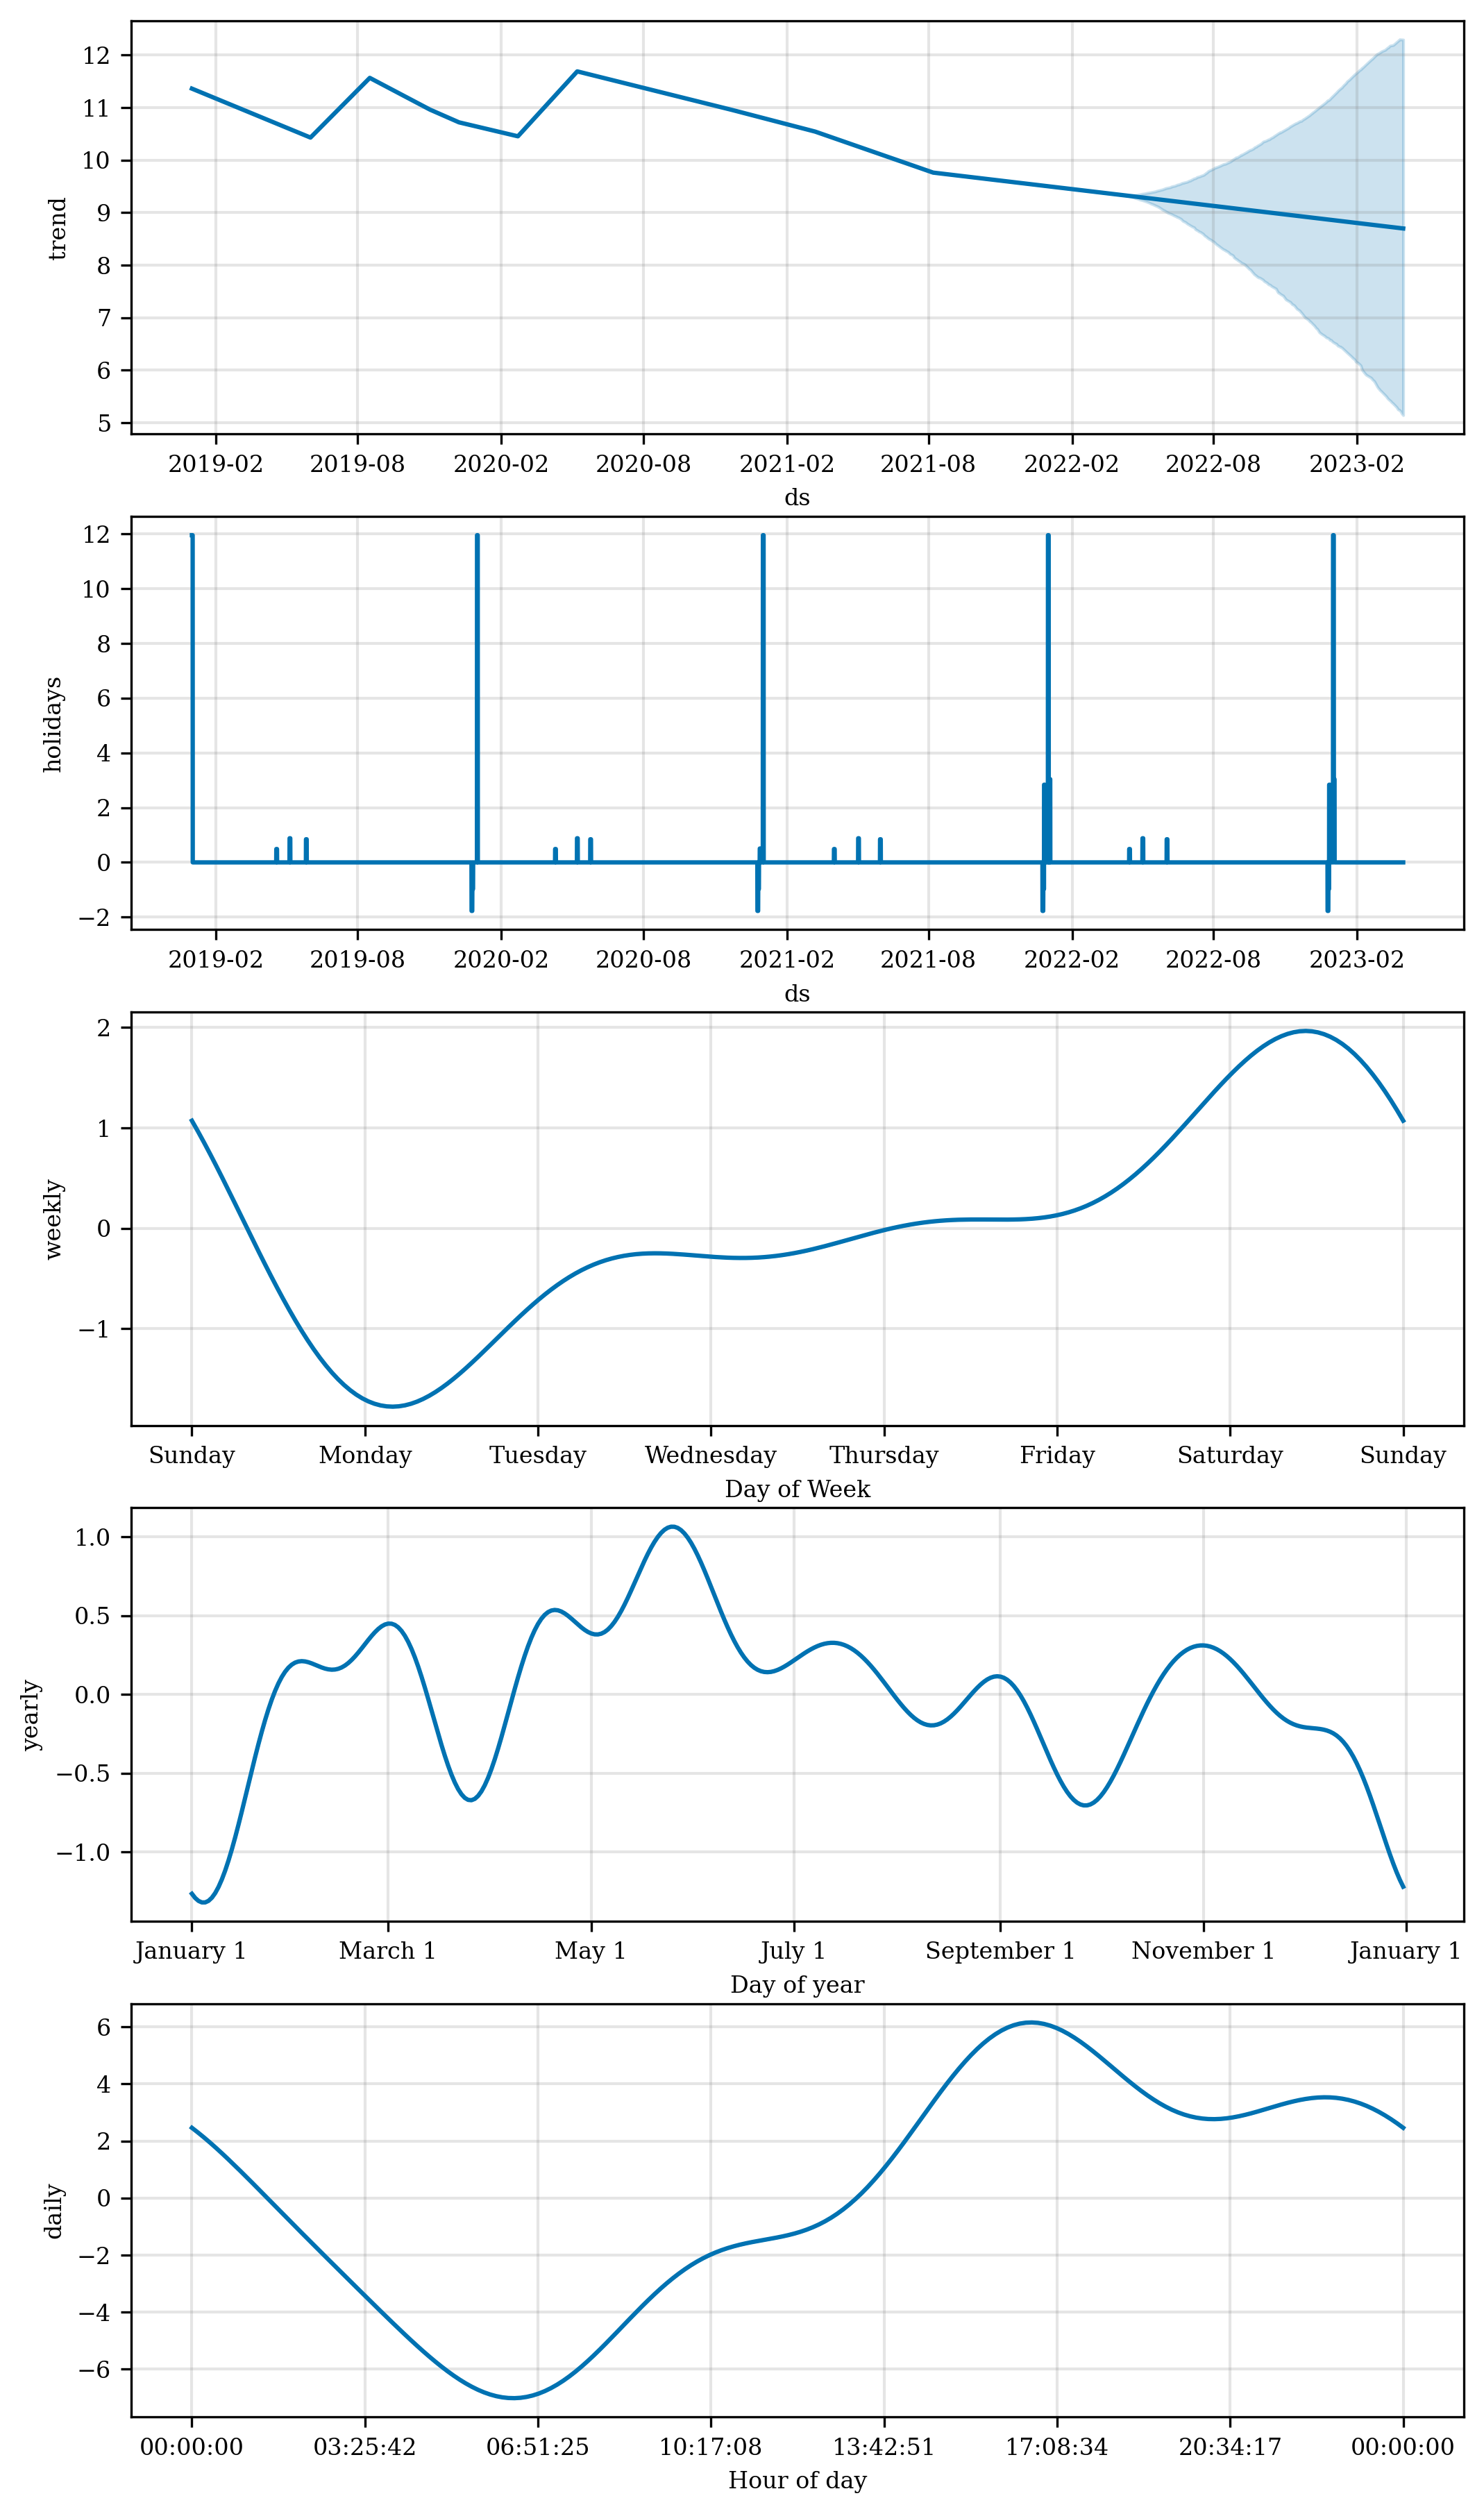

In [12]:
#plot the decomposed time series
plt.rcParams['font.size'] = 8
fig2 = m.plot_components(forecast)
ax = fig2.gca()
fig = plt.gcf()
fig.set_size_inches(7, 12)
fig.dpi = 300
fig.savefig('prophet_forecast_components_hourly.png', bbox_inches='tight', dpi=300)

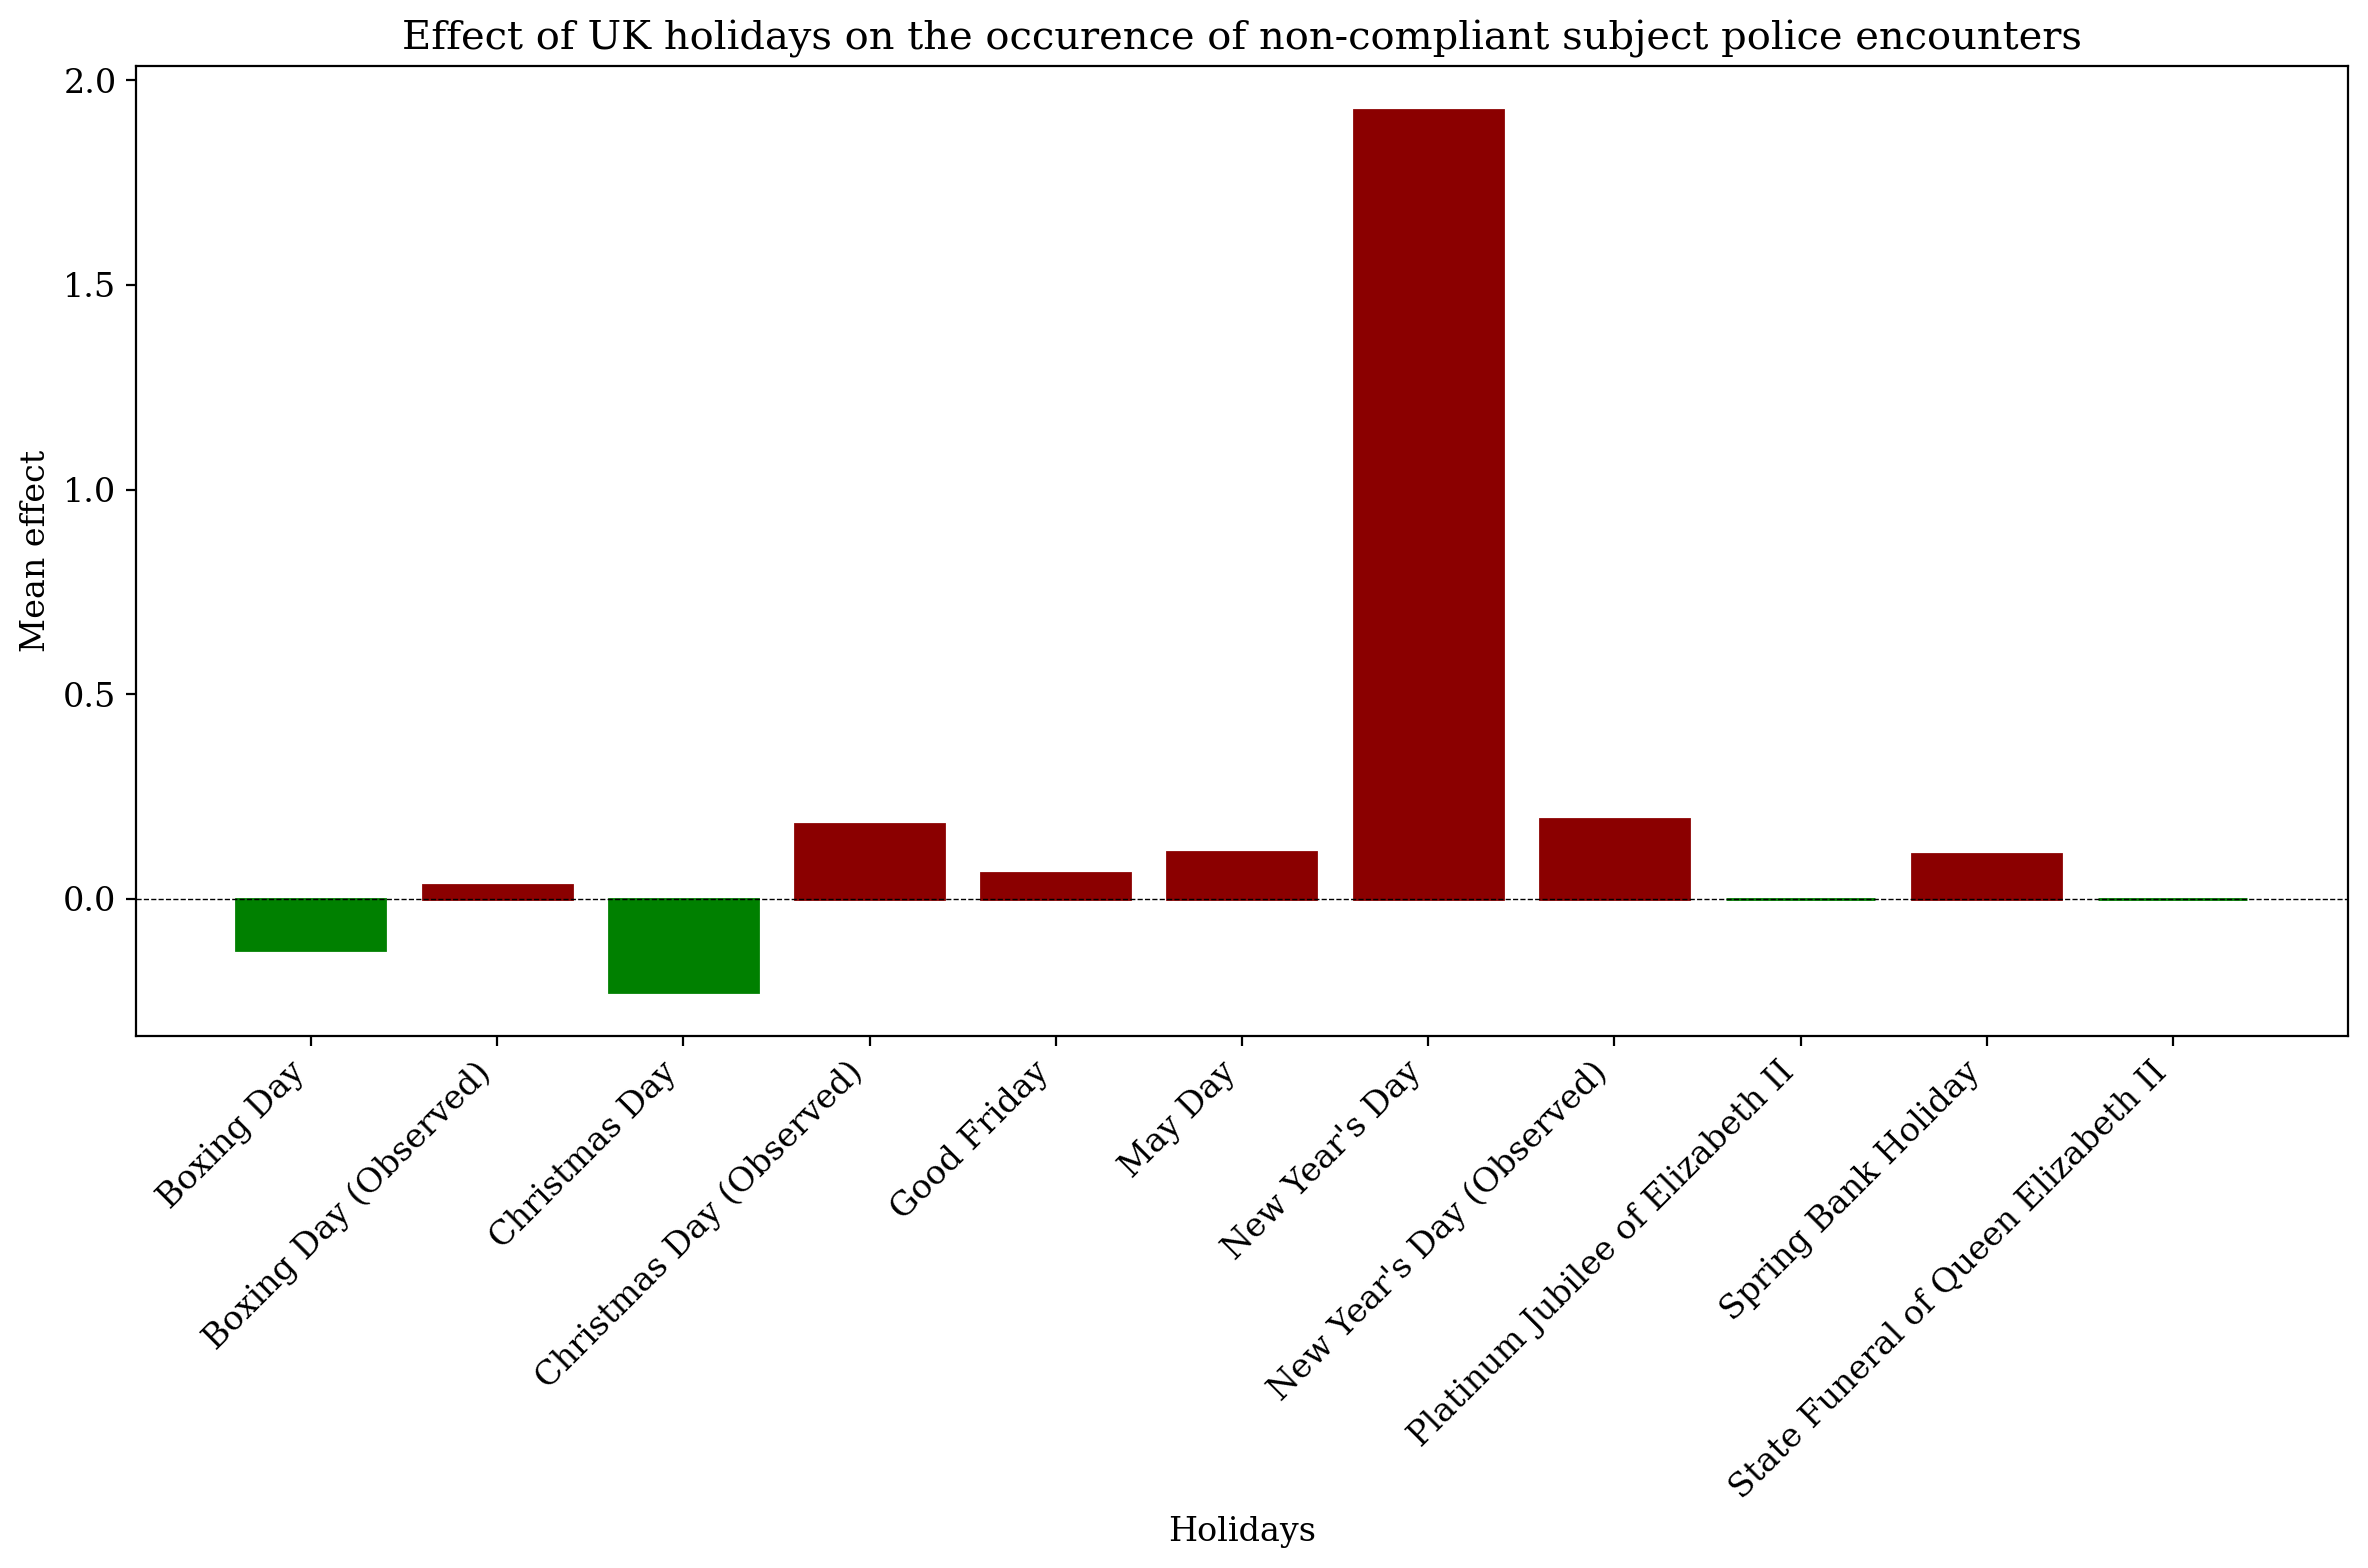

In [13]:
#filter only dates with holidays
holiday_cols = ['Boxing Day', 'Boxing Day (Observed)', 'Christmas Day', 'Christmas Day (Observed)',
                   'Good Friday', 'May Day', "New Year's Day", "New Year's Day (Observed)",
                   "Platinum Jubilee of Elizabeth II", "Spring Bank Holiday", 'State Funeral of Queen Elizabeth II']
holidays_effect = forecast[forecast[holiday_cols].sum(axis=1) != 0]

#compute the mean effect for each holiday
holiday_effects = {}
for holiday in holiday_cols:
    holiday_effects[holiday] = holidays_effect[holiday].mean()
holiday_effect_series = pd.Series(holiday_effects)

#plot the bar chart of the mean effect for each holiday
plt.rcParams['font.size'] = 12
plt.figure(figsize=(12,8), dpi=200)
bars = plt.bar(holiday_effect_series.index, holiday_effect_series.values)

#set the colour of the bars to red if the mean effect is positive, and to green if it is negative
for bar in bars:
    if bar.get_height() > 0:
        bar.set_color('darkred')
    else:
        bar.set_color('green')

plt.title('Effect of UK holidays on the occurence of non-compliant subject police encounters')
plt.ylabel('Mean effect')
plt.xlabel('Holidays')
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('holiday_effects_prophet.png')
plt.show()

In [14]:
cutoff = time_series_hourly['ds'].max() - pd.DateOffset(hours=24*7)

df_train = time_series_hourly[time_series_hourly['ds'] <= cutoff]
df_test = time_series_hourly[time_series_hourly['ds'] > cutoff]

predictions = pd.DataFrame()

future = m.make_future_dataframe(periods=24*7, freq='H')
forecast = m.predict(future)
forecast = forecast[forecast['ds'] > cutoff]
predictions = pd.concat([predictions, forecast], ignore_index=True)

merged = pd.merge(df_test, predictions, on=['ds'], how='inner')

C:\Users\Nikita\AppData\Local\Temp/ipykernel_13264/1301849454.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(merged['ds'], merged['y'], label='Actual', linestyle='-', marker='o', markersize=5)
C:\Users\Nikita\AppData\Local\Temp/ipykernel_13264/1301849454.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(merged['ds'], merged['yhat'], label='Predicted', linestyle='--', marker='o', markersize=2)


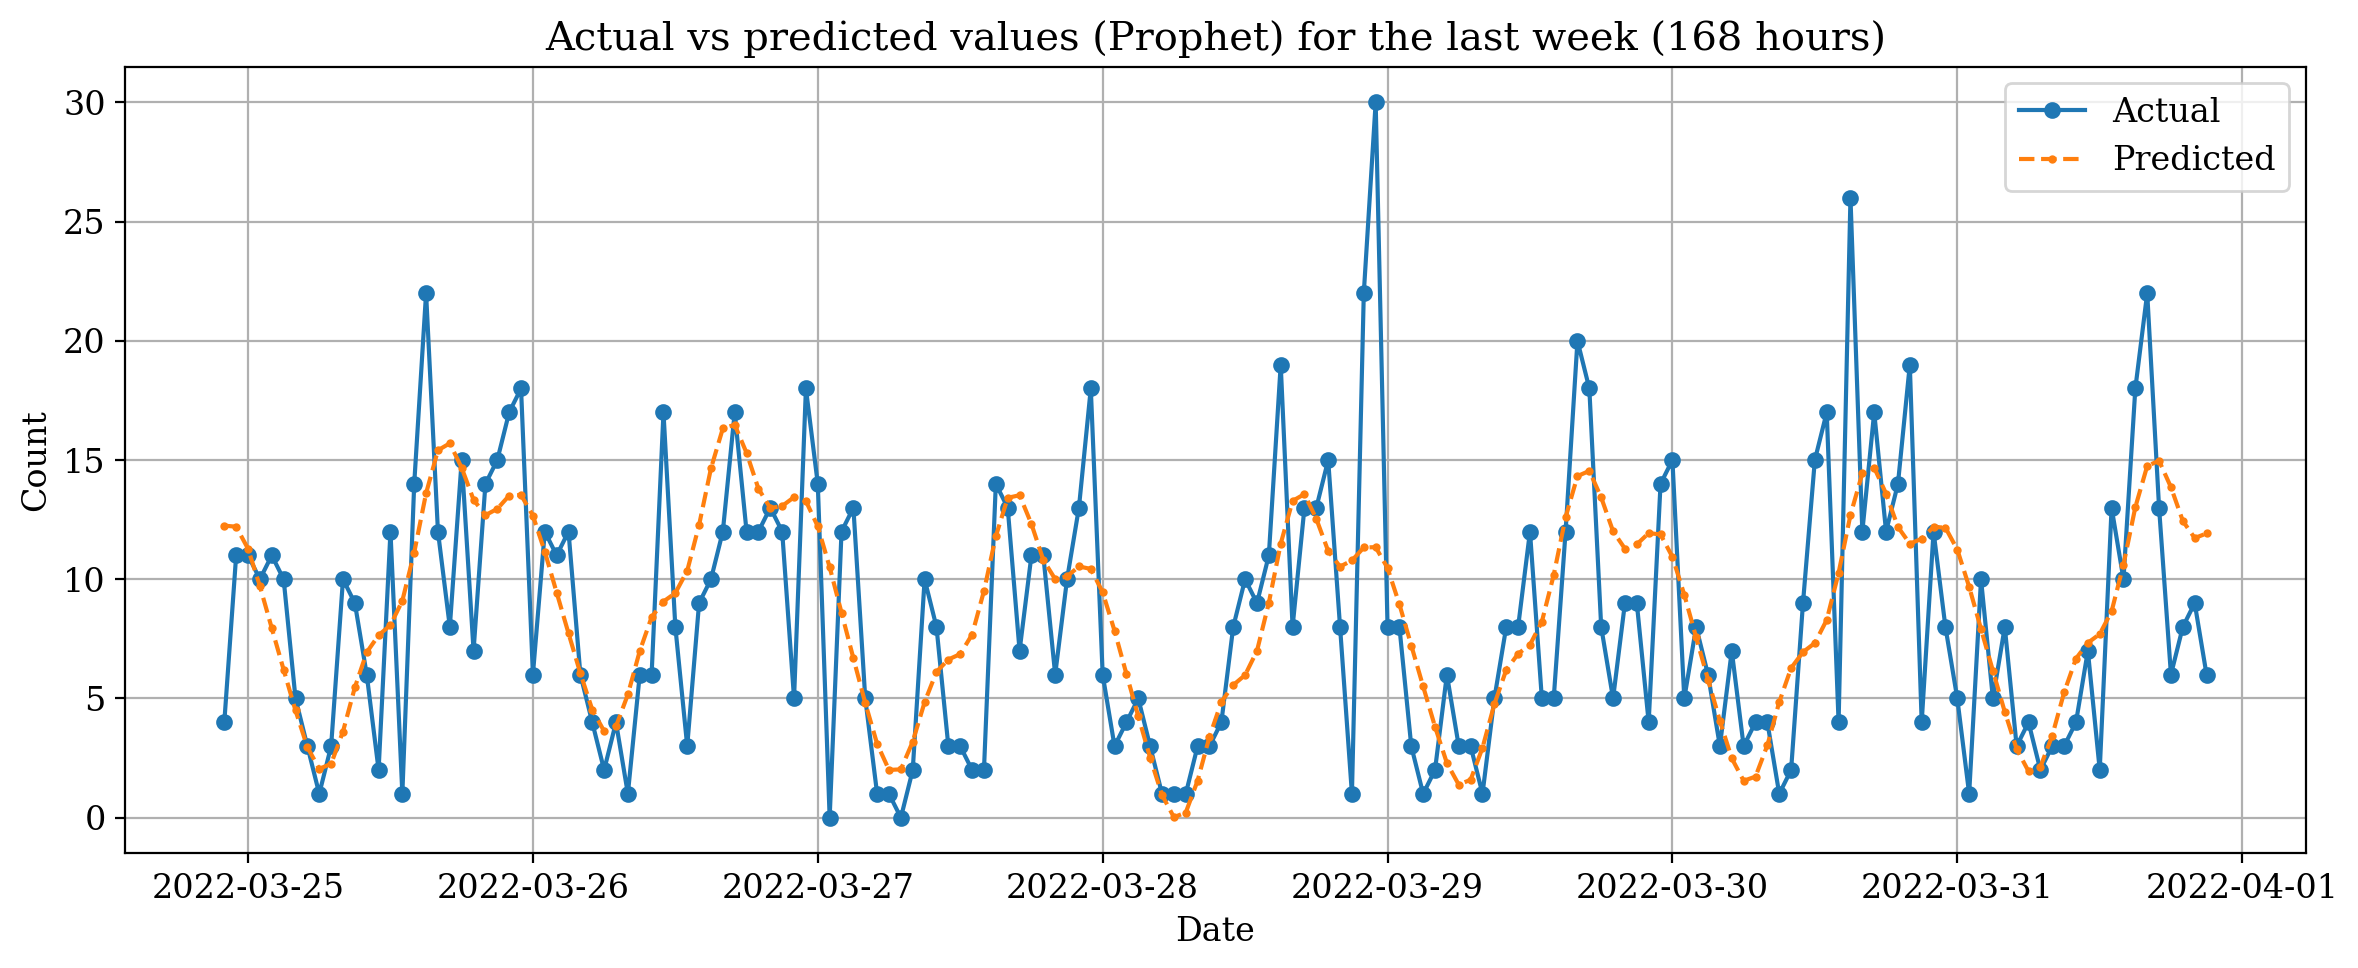

In [15]:
#visualise the actual vs predicted values for the last 60 observations (unseen by the model)
plt.figure(figsize=(12, 5), dpi=200)

plt.plot_date(merged['ds'], merged['y'], label='Actual', linestyle='-', marker='o', markersize=5)
plt.plot_date(merged['ds'], merged['yhat'], label='Predicted', linestyle='--', marker='o', markersize=2)

plt.legend()
plt.title('Actual vs predicted values (Prophet) for the last week (168 hours)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.savefig('prophet_actual_vs_predicted_hourly.png')
plt.show()

In [16]:
#upload the hourly predictions and true labels to the database

# cursor.execute("DROP TABLE IF EXISTS rq3_test_predictions_hourly")
cursor.execute("""
               CREATE TABLE IF NOT EXISTS rq3_test_predictions_hourly (
                    id INT NOT NULL AUTO_INCREMENT,
                    true_label INT,
                    prophet FLOAT,
                    lstm_nn FLOAT,
                    transformer_nn FLOAT,
                    PRIMARY KEY (id));
                    """)

data = [(int(element),) for element in merged['y'].to_numpy()]
query = "INSERT INTO rq3_test_predictions_hourly (true_label) VALUES (%s);"
cursor.executemany(query, data)
db_connection.commit()
cursor.execute("DROP TABLE IF EXISTS temp_table")
cursor.execute("""
               CREATE TEMPORARY TABLE temp_table(
                    id SERIAL PRIMARY KEY, 
                    prophet FLOAT);
                """)

data = [(float(element), i+1) for i, element in enumerate(merged['yhat'].to_numpy())]
query = "INSERT INTO temp_table(prophet, id) VALUES (%s, %s);"
cursor.executemany(query, data)

query = """
    UPDATE rq3_test_predictions_hourly  
    JOIN temp_table 
    ON rq3_test_predictions_hourly.id = temp_table.id
    SET 
        rq3_test_predictions_hourly.prophet = temp_table.prophet;
"""
cursor.execute(query)
cursor.execute("DROP TABLE temp_table;")

db_connection.commit()